# Symbolic Music LLM Scaling Laws - Complete Pipeline

This notebook implements the complete pipeline for the CS-GY 6923 project on scaling laws for symbolic music language models.

## Project Overview

This notebook is organized in logical order:
1. **Setup and Configuration** - Install dependencies and configure paths
2. **Data Collection** - Download and extract Lakh MIDI Dataset
3. **Data Processing Utilities** - MIDI to ABC converter and tokenizer classes
4. **Data Preprocessing** - Convert MIDI files to ABC notation
5. **Tokenization** - Build vocabulary and tokenize sequences
6. **Data Splitting** - Create train/validation/test splits
7. **Model Architecture** - Define Transformer and RNN models
8. **Data Loading Utilities** - Dataset and DataLoader classes
9. **Training Utilities** - Training functions and evaluation
10. **Model Configurations** - Define model sizes for scaling study
11. **Device Setup** - Initialize GPU/CPU device
12. **Transformer Scaling Study** - Train 5 transformer model sizes
13. **RNN Scaling Study** - Train RNN models for comparison
14. **Scaling Analysis** - Plot scaling laws and fit power laws
15. **Sample Generation** - Train best model and generate music samples
16. **Summary** - Final results and conclusions



## Output Files

All outputs are saved to `data/processed/`:
- ABC files: `data/processed/abc/`
- Tokenized data: `data/processed/tokenized/`
- Models: `data/processed/`
- Samples: `data/processed/samples/`
- Results: `data/processed/scaling_results.json`


In [76]:
# Install required packages
%pip install -q music21 pretty_midi librosa mir_eval numpy pandas scipy torch transformers datasets matplotlib seaborn tqdm pyyaml wandb joblib


# Part 1: Setup and Configuration

This section sets up the environment, installs dependencies, and configures paths for the project.

## 1.1 Install Dependencies

Install all required packages for music processing, deep learning, and visualization.


In [77]:
import os
import sys
import json
import pickle
import warnings
from pathlib import Path
from collections import Counter
from typing import List, Tuple, Dict, Optional
import random
import gc
import io
import contextlib

# Aggressively suppress all warnings, especially from music21
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

import music21
music21.environment.UserSettings()['warnings'] = 0

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import math

# Setup paths for Colab
if 'google.colab' in str(get_ipython()):
    BASE_DIR = Path('/content/symbolic-music-llm')
    BASE_DIR.mkdir(exist_ok=True)
    os.chdir(BASE_DIR)
else:
    BASE_DIR = Path.cwd()

DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "data" / "processed"
LMD_DIR = DATA_DIR / "lmd_matched"

# Create directories
DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
(OUTPUT_DIR / "abc").mkdir(exist_ok=True)
(OUTPUT_DIR / "tokenized").mkdir(exist_ok=True)

print(f"Working directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")


Working directory: /content/symbolic-music-llm
Data directory: /content/symbolic-music-llm/data
Output directory: /content/symbolic-music-llm/data/processed


# Part 2: Model Architecture

This section defines the neural network architectures used for symbolic music generation. The code is based on `models/transformer.py` and includes both Transformer and RNN/LSTM models.

## 2.1 Transformer Architecture

The Transformer model uses a decoder-only architecture (similar to GPT) with:
- Multi-head causal self-attention
- Feedforward networks with GELU activation
- Layer normalization and residual connections
- Positional embeddings


In [78]:
# Transformer Model Classes
class CausalSelfAttention(nn.Module):
    """Multi-head causal self-attention block."""

    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.c_attn = nn.Linear(d_model, 3 * d_model)
        self.c_proj = nn.Linear(d_model, d_model)
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.d_model, dim=2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        y = F.scaled_dot_product_attention(q, k, v, dropout_p=0.1 if self.training else 0, is_causal=True)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y


class MLP(nn.Module):
    """Feedforward network with GELU activation."""

    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.c_fc = nn.Linear(d_model, d_ff)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    """Transformer block: attention + feedforward with residual connections."""

    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.ln_1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout)
        self.ln_2 = nn.LayerNorm(d_model)
        self.mlp = MLP(d_model, d_ff, dropout)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class MusicTransformer(nn.Module):
    """Decoder-only Transformer for symbolic music generation."""

    def __init__(self, vocab_size, d_model=512, n_layers=6, n_heads=8,
                 d_ff=None, max_seq_length=5000, dropout=0.1):
        super().__init__()

        if d_ff is None:
            d_ff = 4 * d_model

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.d_ff = d_ff
        self.max_seq_length = max_seq_length

        self.wte = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.wpe = nn.Embedding(max_seq_length, d_model)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            Block(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        # Tie weights
        self.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        tok_emb = self.wte(idx)
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.wpe(pos)
        x = self.drop(tok_emb + pos_emb)

        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-1
            )

        return logits, loss

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """Generate new tokens given a context."""
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.max_seq_length:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# RNN/LSTM Model Classes
class MusicLSTM(nn.Module):
    """LSTM-based model for symbolic music generation."""

    def __init__(self, vocab_size, d_model=512, n_layers=2, dropout=0.1, max_seq_length=5000):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.max_seq_length = max_seq_length

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)

        # LSTM layers
        self.lstm = nn.LSTM(
            d_model,
            d_model,
            num_layers=n_layers,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # Output projection
        self.dropout = nn.Dropout(dropout)
        self.lm_head = nn.Linear(d_model, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.size()

        # Embedding
        x = self.embedding(idx)  # (B, T, d_model)
        x = self.dropout(x)

        # LSTM
        lstm_out, _ = self.lstm(x)  # (B, T, d_model)
        lstm_out = self.dropout(lstm_out)

        # Output projection
        logits = self.lm_head(lstm_out)  # (B, T, vocab_size)

        # Compute loss if targets provided
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-1
            )

        return logits, loss

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """Generate new tokens given a context."""
        self.eval()
        for _ in range(max_new_tokens):
            # Crop context if needed
            idx_cond = idx[:, -self.max_seq_length:] if idx.size(1) > self.max_seq_length else idx

            # Forward pass
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            # Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Sample
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

print("Model classes defined (Transformer + LSTM)!")


Model classes defined (Transformer + LSTM)!


# Part 3: Data Processing Utilities

This section includes utilities for converting MIDI to ABC notation and tokenizing music sequences. The code is based on `data-collection-and-preprocessing/midi_to_abc.py` and `data-collection-and-preprocessing/tokenizer.py`.

## 3.1 MIDI to ABC Converter

The `MIDIToABCConverter` class converts MIDI files to ABC notation using music21. This handles:
- Parsing MIDI files
- Extracting musical elements (notes, rests, chords)
- Converting to ABC format with proper headers
- Cleaning and normalizing output


In [79]:
# MIDI to ABC Converter
class MIDIToABCConverter:
    """Convert MIDI files to ABC notation using music21."""

    def __init__(self):
        self.conversion_stats = {'success': 0, 'failed': 0, 'errors': []}

    def convert_midi_to_abc(self, midi_path: Path) -> Optional[str]:
        """Convert a MIDI file to ABC notation."""
        try:
            null_stderr = io.StringIO()
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                with contextlib.redirect_stderr(null_stderr):
                    score = music21.converter.parse(str(midi_path))

            abc_str = self._score_to_abc_manual(score)

            if abc_str:
                abc_str = self._clean_abc(abc_str)
                if len(abc_str.strip()) > 0:
                    self.conversion_stats['success'] += 1
                    return abc_str

            self.conversion_stats['failed'] += 1
            return None
        except Exception as e:
            self.conversion_stats['failed'] += 1
            self.conversion_stats['errors'].append(str(e))
            return None

    def _score_to_abc_manual(self, score) -> str:
        """Manually convert music21 score to ABC notation."""
        try:
            abc_lines = []

            # ABC header
            abc_lines.append("X:1")
            abc_lines.append("M:4/4")  # Default time signature
            abc_lines.append("L:1/8")  # Default note length
            abc_lines.append("K:C")     # Default key

            # Extract time signature if available
            for ts in score.flat.getElementsByClass('TimeSignature'):
                if ts.numerator and ts.denominator:
                    abc_lines[1] = f"M:{ts.numerator}/{ts.denominator}"
                    break

            # Extract key signature if available
            try:
                key = score.analyze('key')
                if key:
                    key_name = key.tonic.name
                    mode = 'maj' if key.mode == 'major' else 'min'
                    abc_lines[3] = f"K:{key_name}{mode[0]}"
            except:
                pass

            # Convert notes to ABC body
            abc_body = []
            measure_count = 0

            for element in score.flat.notesAndRests:
                if isinstance(element, music21.note.Note):
                    abc_body.append(self._note_to_abc(element))
                elif isinstance(element, music21.note.Rest):
                    dur = self._duration_to_abc(element.duration.quarterLength)
                    abc_body.append("z" + dur)
                elif isinstance(element, music21.chord.Chord):
                    # Handle chords (simplified: use first note)
                    if len(element.notes) > 0:
                        abc_body.append(self._note_to_abc(element.notes[0]))

                # Add bar lines periodically
                measure_count += 1
                if measure_count % 4 == 0:
                    abc_body.append("|")

            body_str = "".join(abc_body)
            if len(body_str) > 80:
                parts = body_str.split("|")
                formatted_parts = []
                for part in parts:
                    if len(part) > 80:
                        words = part.split()
                        line = []
                        for word in words:
                            if len(" ".join(line + [word])) > 80 and line:
                                formatted_parts.append(" ".join(line))
                                line = [word]
                            else:
                                line.append(word)
                        if line:
                            formatted_parts.append(" ".join(line))
                    else:
                        formatted_parts.append(part)
                body_str = "|".join(formatted_parts)

            abc_lines.append(body_str)
            return "\n".join(abc_lines) if abc_lines else ""
        except Exception as e:
            return ""

    def _note_to_abc(self, note) -> str:
        """Convert a music21 note to ABC notation."""
        try:
            note_name = note.pitch.name[0]

            if note.pitch.accidental:
                if note.pitch.accidental.alter == 1:
                    note_name = "^" + note_name
                elif note.pitch.accidental.alter == -1:
                    note_name = "_" + note_name

            octave = note.pitch.octave
            if octave < 4:
                note_name = note_name.lower() * (4 - octave)
            elif octave > 4:
                note_name = note_name + "'" * (octave - 4)

            dur = self._duration_to_abc(note.duration.quarterLength)
            return note_name + dur
        except Exception:
            return ""

    def _duration_to_abc(self, quarter_length: float) -> str:
        """Convert duration in quarter notes to ABC notation."""
        eighth_notes = quarter_length * 2
        eighth_notes = round(eighth_notes * 8) / 8

        if eighth_notes <= 0:
            return ""
        elif eighth_notes == 0.5:
            return "/"
        elif eighth_notes == 1.0:
            return ""
        elif eighth_notes == 2.0:
            return "2"
        elif eighth_notes == 3.0:
            return "3"
        elif eighth_notes == 4.0:
            return "4"
        elif eighth_notes == 6.0:
            return "6"
        elif eighth_notes == 8.0:
            return "8"
        else:
            dur_int = int(eighth_notes)
            if dur_int > 0 and dur_int <= 16:
                return str(dur_int)
            else:
                return f"/{int(1/eighth_notes)}" if eighth_notes < 1 else str(int(eighth_notes))

    def _clean_abc(self, abc_str: str) -> str:
        """Clean and normalize ABC notation string."""
        lines = abc_str.split('\n')
        cleaned_lines = []
        for line in lines:
            line = line.strip()
            if line and not line.startswith('%'):
                cleaned_lines.append(line)
        return '\n'.join(cleaned_lines)

print("MIDI to ABC converter defined!")


MIDI to ABC converter defined!


## 3.2 Music Tokenizer

The `MusicTokenizer` class tokenizes ABC notation into music-aware tokens:
- Handles notes, durations, rests, and bar lines
- Builds vocabulary from training data
- Encodes/decodes between ABC strings and token IDs
- Supports special tokens for padding, unknown tokens, etc.


In [80]:
# Music Tokenizer
class MusicTokenizer:
    """Tokenizer for ABC notation."""

    def __init__(self):
        self.vocab = {}
        self.vocab_size = 0
        self.token_to_id = {}
        self.id_to_token = {}
        self.special_tokens = {
            '<PAD>': 0,
            '<UNK>': 1,
            '<START>': 2,
            '<END>': 3,
            '<SEP>': 4,
        }

    def build_vocab(self, abc_strings: List[str], min_freq: int = 2):
        """Build vocabulary from ABC strings."""
        print("Building vocabulary...")
        token_counter = Counter()

        for abc_str in tqdm(abc_strings, desc="Tokenizing for vocab"):
            tokens = self._tokenize_abc(abc_str)
            token_counter.update(tokens)

        vocab = dict(self.special_tokens)
        current_id = len(self.special_tokens)

        for token, count in token_counter.items():
            if count >= min_freq:
                vocab[token] = current_id
                current_id += 1

        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.token_to_id = vocab
        self.id_to_token = {v: k for k, v in vocab.items()}

        print(f"Vocabulary size: {self.vocab_size}")
        print(f"  Special tokens: {len(self.special_tokens)}")
        print(f"  Regular tokens: {self.vocab_size - len(self.special_tokens)}")

    def _tokenize_abc(self, abc_str: str) -> List[str]:
        """Tokenize ABC notation string into music-aware tokens."""
        tokens = []
        i = 0

        while i < len(abc_str):
            char = abc_str[i]

            if char.isspace():
                i += 1
                continue

            if char == '|':
                tokens.append('|')
                i += 1
                continue

            if char.upper() in 'ABCDEFG':
                note_token = char.upper()
                i += 1

                if i < len(abc_str) and abc_str[i] in '^_':
                    note_token += abc_str[i]
                    i += 1

                while i < len(abc_str) and abc_str[i] in ",'":
                    note_token += abc_str[i]
                    i += 1

                tokens.append(note_token)
                continue

            if char.isdigit():
                duration = char
                i += 1
                while i < len(abc_str) and abc_str[i].isdigit():
                    duration += abc_str[i]
                    i += 1
                tokens.append(f"DUR:{duration}")
                continue

            if char == 'z':
                tokens.append('z')
                i += 1
                continue

            tokens.append(char)
            i += 1

        return tokens

    def encode(self, abc_str: str) -> List[int]:
        """Encode ABC string to token IDs."""
        tokens = self._tokenize_abc(abc_str)
        token_ids = []
        for token in tokens:
            if token in self.token_to_id:
                token_ids.append(self.token_to_id[token])
            else:
                token_ids.append(self.token_to_id['<UNK>'])
        return token_ids

    def decode(self, token_ids: List[int]) -> str:
        """Decode token IDs back to ABC string."""
        tokens = []
        for token_id in token_ids:
            if token_id in self.id_to_token:
                tokens.append(self.id_to_token[token_id])
            else:
                tokens.append('<UNK>')
        return ' '.join(tokens)

    def save(self, path: Path):
        """Save tokenizer to disk."""
        with open(path, 'wb') as f:
            pickle.dump({
                'vocab': self.vocab,
                'token_to_id': self.token_to_id,
                'id_to_token': self.id_to_token,
                'vocab_size': self.vocab_size,
                'special_tokens': self.special_tokens
            }, f)

    @classmethod
    def load(cls, path: Path):
        """Load tokenizer from disk."""
        with open(path, 'rb') as f:
            data = pickle.load(f)
        tokenizer = cls()
        tokenizer.vocab = data['vocab']
        tokenizer.token_to_id = data['token_to_id']
        tokenizer.id_to_token = data['id_to_token']
        tokenizer.vocab_size = data['vocab_size']
        tokenizer.special_tokens = data['special_tokens']
        return tokenizer

print("Music tokenizer defined!")


Music tokenizer defined!


## 4. Data Collection

This section downloads and extracts the Lakh MIDI Dataset (LMD-matched) to the `/data` folder.

**Note**: The dataset is ~1.7GB compressed and ~2-3GB extracted. This may take several minutes to download.


In [ ]:
# Data Collection: Download and Extract Lakh MIDI Dataset
import urllib.request
import tarfile
import shutil

LMD_URL = "http://hog.ee.columbia.edu/craffel/lmd/lmd_matched.tar.gz"
TAR_PATH = DATA_DIR / "lmd_matched.tar.gz"

def download_with_progress(url: str, destination: Path):
    """Download file with progress bar."""
    def reporthook(count, block_size, total_size):
        percent = int(count * block_size * 100 / total_size)
        print(f"\rDownloading... {percent}% ({count * block_size / 1024 / 1024:.1f} MB / {total_size / 1024 / 1024:.1f} MB)", end='', flush=True)

    try:
        urllib.request.urlretrieve(url, destination, reporthook=reporthook)
        print("\nDownload complete!")
        return True
    except Exception as e:
        print(f"\nERROR: Download failed: {e}")
        return False

# Check if dataset already exists
if LMD_DIR.exists() and len(list(LMD_DIR.rglob("*.mid"))) > 0:
    print(f"LMD dataset already exists in {LMD_DIR}")
    print(f"  Found {len(list(LMD_DIR.rglob('*.mid')))} MIDI files")
else:
    print("LMD dataset not found. Starting download...")
    print(f"URL: {LMD_URL}")
    print(f"Destination: {TAR_PATH}")
    print(f"Note: This is a large file (~1.7GB), download may take 5-15 minutes depending on connection speed.\n")

    # Download the dataset
    if not TAR_PATH.exists():
        if download_with_progress(LMD_URL, TAR_PATH):
            print(f"Downloaded to {TAR_PATH}")
        else:
            print("ERROR: Download failed. Please check your internet connection and try again.")
            raise RuntimeError("Failed to download LMD dataset")
    else:
        print(f"Tar file already exists: {TAR_PATH}")

    # Extract the dataset
    print(f"\nExtracting {TAR_PATH} to {DATA_DIR}...")
    print("This may take a few minutes...")

    try:
        with tarfile.open(TAR_PATH, 'r:gz') as tar:
            # Get total members for progress
            members = tar.getmembers()
            total = len(members)

            # Extract with progress
            for i, member in enumerate(members):
                tar.extract(member, DATA_DIR)
                if (i + 1) % 1000 == 0:
                    print(f"  Extracted {i+1}/{total} files...", end='\r', flush=True)
                    print(f"\nExtracted {total} files")
        
        # The tar file might extract to a folder with a different name
        # Check for extracted folders and rename if needed
        extracted_folders = [d for d in DATA_DIR.iterdir() 
                           if d.is_dir() and 'lmd' in d.name.lower() and d != LMD_DIR]
        
        if extracted_folders and not LMD_DIR.exists():
            if len(extracted_folders) == 1:
                print(f"Renaming {extracted_folders[0]} to {LMD_DIR}")
                extracted_folders[0].rename(LMD_DIR)
        
        # Clean up tar file to save space (optional - comment out if you want to keep it)
        # TAR_PATH.unlink()
        # print(f"Removed tar file to save space")
        
    except Exception as e:
        print(f"ERROR: Extraction failed: {e}")
        raise RuntimeError(f"Failed to extract dataset: {e}")

# Verify MIDI files are available
midi_files = list(LMD_DIR.rglob("*.mid"))
print(f"\n{'='*60}")
print(f"Data Collection Summary:")
print(f"{'='*60}")
print(f"MIDI files found: {len(midi_files):,}")
print(f"Location: {LMD_DIR}")

if len(midi_files) == 0:
    print("\nWARNING: No MIDI files found!")
    print("Please check:")
    print(f"  1. Extraction completed successfully")
    print(f"  2. Files are in: {LMD_DIR}")
    print(f"  3. Directory structure is correct")
    raise RuntimeError("No MIDI files found after download/extraction")

# Limit to 5,000 files for this run
MAX_FILES = 5000
if len(midi_files) > MAX_FILES:
    print(f"\nLimiting to {MAX_FILES} files for processing")
    midi_files = midi_files[:MAX_FILES]

print(f"\nReady to process {len(midi_files):,} MIDI files")
print(f"{'='*60}")


✓ LMD dataset already exists in /content/symbolic-music-llm/data/lmd_matched
  Found 116189 MIDI files

Data Collection Summary:
MIDI files found: 116,189
Location: /content/symbolic-music-llm/data/lmd_matched

Limiting to 1000 files for processing

✓ Ready to process 1,000 MIDI files


# Part 5: Data Processing - Convert MIDI to ABC Notation

This section processes the downloaded MIDI files and converts them to ABC notation format. The code uses parallel processing for efficiency, based on `data-collection-and-preprocessing/process_pipeline.py`.

**Processing**: Up to 1,000 MIDI files will be converted to ABC notation using parallel workers.


In [ ]:
# Convert MIDI files to ABC notation (PARALLEL PROCESSING with ProcessPoolExecutor)
# Note: For Jupyter notebooks, we use a self-contained worker function to avoid pickling issues
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import cpu_count, Pool
import time

def convert_single_midi_worker(args):
    """
    Convert a single MIDI file to ABC (for parallel processing).
    This function is completely self-contained to avoid pickling issues in notebooks.
    """
    midi_file, output_dir = args

    try:
        # Import all necessary modules in worker process
        import warnings
        import io
        import contextlib
        from pathlib import Path
        import music21

        # Suppress warnings in worker process
        warnings.filterwarnings('ignore')
        music21.environment.UserSettings()['warnings'] = 0

        # Helper function: duration to ABC
        def duration_to_abc(quarter_length):
            eighth_notes = quarter_length * 2
            eighth_notes = round(eighth_notes * 8) / 8
            if eighth_notes <= 0:
                return ""
            elif eighth_notes == 0.5:
                return "/"
            elif eighth_notes == 1.0:
                return ""
            elif eighth_notes == 2.0:
                return "2"
            elif eighth_notes == 3.0:
                return "3"
            elif eighth_notes == 4.0:
                return "4"
            elif eighth_notes == 6.0:
                return "6"
            elif eighth_notes == 8.0:
                return "8"
            else:
                dur_int = int(eighth_notes)
                if dur_int > 0 and dur_int <= 16:
                    return str(dur_int)
                else:
                    return f"/{int(1/eighth_notes)}" if eighth_notes < 1 else str(int(eighth_notes))

        # Helper function: note to ABC
        def note_to_abc(note):
            try:
                note_name = note.pitch.name[0]
                if note.pitch.accidental:
                    if note.pitch.accidental.alter == 1:
                        note_name = "^" + note_name
                    elif note.pitch.accidental.alter == -1:
                        note_name = "_" + note_name
                octave = note.pitch.octave
                if octave < 4:
                    note_name = note_name.lower() * (4 - octave)
                elif octave > 4:
                    note_name = note_name + "'" * (octave - 4)
                dur = duration_to_abc(note.duration.quarterLength)
                return note_name + dur
            except Exception:
                return ""

        # Parse MIDI file
        null_stderr = io.StringIO()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            with contextlib.redirect_stderr(null_stderr):
                score = music21.converter.parse(str(midi_file))

        # Convert to ABC manually
        abc_lines = []
        abc_lines.append("X:1")
        abc_lines.append("M:4/4")
        abc_lines.append("L:1/8")
        abc_lines.append("K:C")

        # Extract time signature if available
        for ts in score.flat.getElementsByClass('TimeSignature'):
            if ts.numerator and ts.denominator:
                abc_lines[1] = f"M:{ts.numerator}/{ts.denominator}"
                break

        # Extract key signature if available
        try:
            key = score.analyze('key')
            if key:
                key_name = key.tonic.name
                mode = 'maj' if key.mode == 'major' else 'min'
                abc_lines[3] = f"K:{key_name}{mode[0]}"
        except:
            pass

        # Convert notes to ABC body
        abc_body = []
        measure_count = 0

        for element in score.flat.notesAndRests:
            if isinstance(element, music21.note.Note):
                abc_body.append(note_to_abc(element))
            elif isinstance(element, music21.note.Rest):
                dur = duration_to_abc(element.duration.quarterLength)
                abc_body.append("z" + dur)
            elif isinstance(element, music21.chord.Chord):
                if len(element.notes) > 0:
                    abc_body.append(note_to_abc(element.notes[0]))

            measure_count += 1
            if measure_count % 4 == 0:
                abc_body.append("|")

        body_str = "".join(abc_body)
        abc_lines.append(body_str)
        abc_str = "\n".join(abc_lines) if abc_lines else ""

        if abc_str:
            # Clean ABC string
            lines = abc_str.split('\n')
            cleaned_lines = []
            for line in lines:
                line = line.strip()
                if line and not line.startswith('%'):
                    cleaned_lines.append(line)
            abc_str = '\n'.join(cleaned_lines)

            if len(abc_str.strip()) > 0:
                # Save ABC file
                abc_path = Path(output_dir) / "abc" / f"{Path(midi_file).stem}.abc"
                abc_path.parent.mkdir(parents=True, exist_ok=True)

                try:
                    with open(abc_path, 'w') as f:
                        f.write(abc_str)

                    # Verify file was written
                    if abc_path.exists() and abc_path.stat().st_size > 0:
                        return (str(midi_file), abc_str)
                except Exception as e:
                    return None

        return None
    except Exception as e:
        return None
    finally:
        # Force garbage collection
        import gc
        gc.collect()


# For notebooks, we'll use a simpler approach that works with multiprocessing
# The worker function is already self-contained, so we can use it directly


# Setup parallel processing using joblib (works better in notebooks)
NUM_WORKERS = 14  # Use 14 parallel workers
CHUNK_SIZE = 500  # Process in chunks to manage memory

print(f"Converting {len(midi_files)} MIDI files to ABC notation...")
print(f"Using {NUM_WORKERS} parallel workers with joblib (notebook-friendly)")
print(f"Processing in chunks of {CHUNK_SIZE} files\n")

# Try to use joblib for parallel processing (works better in notebooks)
try:
    from joblib import Parallel, delayed
    USE_JOBLIB = True
    print("joblib available - using parallel processing")
except ImportError:
    USE_JOBLIB = False
    print("WARNING: joblib not available - using sequential processing")
    print("  Install with: pip install joblib")

# Prepare arguments for processing
args_list = [(str(midi_file), str(OUTPUT_DIR)) for midi_file in midi_files]

# Process in chunks to prevent memory buildup
abc_data = []
conversion_stats = {'success': 0, 'failed': 0}

total_chunks = (len(args_list) + CHUNK_SIZE - 1) // CHUNK_SIZE
start_time = time.time()

for chunk_idx in range(total_chunks):
    start_idx = chunk_idx * CHUNK_SIZE
    end_idx = min(start_idx + CHUNK_SIZE, len(args_list))
    chunk_args = args_list[start_idx:end_idx]

    print(f"Processing chunk {chunk_idx + 1}/{total_chunks} (files {start_idx + 1}-{end_idx})...")
    chunk_start_time = time.time()

    chunk_results = []

    # Process chunk - use joblib for parallel processing if available
    if USE_JOBLIB:
        # Use joblib.Parallel which handles notebooks better
        try:
            print(f"  Processing with {NUM_WORKERS} parallel workers...")
            # joblib.Parallel with verbose=1 shows progress, but we'll use tqdm wrapper
            def process_with_progress(args_list):
                """Process with progress tracking."""
                results = []
                for args in tqdm(args_list, desc=f"Chunk {chunk_idx + 1}/{total_chunks}", leave=False):
                    results.append(convert_single_midi_worker(args))
                return results

            # Use joblib for parallel processing
            chunk_results = Parallel(n_jobs=NUM_WORKERS, backend='loky', verbose=0)(
                delayed(convert_single_midi_worker)(args) for args in chunk_args
            )
            print(f"  Completed chunk {chunk_idx + 1}/{total_chunks}")
        except Exception as e:
            print(f"  joblib parallel failed ({e}), falling back to sequential")
            USE_JOBLIB = False
            # Fall through to sequential processing

    if not USE_JOBLIB:
        # Sequential processing (optimized)
        converter = MIDIToABCConverter()
        chunk_results = []

        for midi_file_str, output_dir_str in tqdm(chunk_args, desc=f"Chunk {chunk_idx + 1}/{total_chunks}"):
            midi_file = Path(midi_file_str)
            abc_str = converter.convert_midi_to_abc(midi_file)

            if abc_str:
                abc_path = Path(output_dir_str) / "abc" / f"{midi_file.stem}.abc"
                abc_path.parent.mkdir(parents=True, exist_ok=True)
                try:
                    with open(abc_path, 'w') as f:
                        f.write(abc_str)
                    if abc_path.exists() and abc_path.stat().st_size > 0:
                        chunk_results.append((str(midi_file), abc_str))
                    else:
                        chunk_results.append(None)
                except Exception as e:
                    chunk_results.append(None)
            else:
                chunk_results.append(None)

            # Periodic garbage collection every 50 files
            if len(chunk_results) % 50 == 0:
                gc.collect()

    # Collect results
    for result in chunk_results:
        if result is not None:
            abc_data.append(result)
            conversion_stats['success'] += 1
        else:
            conversion_stats['failed'] += 1

    # Force garbage collection between chunks
    gc.collect()

    # Print progress
    chunk_time = time.time() - chunk_start_time
    progress = (chunk_idx + 1) / total_chunks * 100
    elapsed_time = time.time() - start_time
    avg_time_per_file = elapsed_time / (conversion_stats['success'] + conversion_stats['failed']) if (conversion_stats['success'] + conversion_stats['failed']) > 0 else 0
    remaining_files = len(args_list) - (conversion_stats['success'] + conversion_stats['failed'])
    estimated_remaining = remaining_files * avg_time_per_file if avg_time_per_file > 0 else 0

    print(f"  Progress: {progress:.1f}% | "
          f"Success: {conversion_stats['success']} | "
          f"Failed: {conversion_stats['failed']} | "
          f"Chunk time: {chunk_time:.1f}s")
    if estimated_remaining > 0:
        print(f"  Estimated time remaining: {estimated_remaining/60:.1f} minutes\n")
    else:
        print()

total_time = time.time() - start_time

print(f"{'='*60}")
print(f"Conversion complete!")
print(f"{'='*60}")
print(f"  Successful: {conversion_stats['success']:,}")
print(f"  Failed: {conversion_stats['failed']:,}")
if len(midi_files) > 0:
    print(f"  Success rate: {conversion_stats['success'] / len(midi_files) * 100:.1f}%")
print(f"  Total ABC files: {len(abc_data):,}")
print(f"  Total time: {total_time/60:.1f} minutes ({total_time:.1f} seconds)")
if conversion_stats['success'] > 0:
    print(f"  Average time per file: {total_time / len(midi_files):.2f} seconds")
    print(f"  Files per second: {len(midi_files) / total_time:.2f}")
print(f"{'='*60}")

# Convert back to Path objects for consistency
abc_data = [(Path(midi_path), abc_str) for midi_path, abc_str in abc_data]


Converting 1000 MIDI files to ABC notation...
Using 14 parallel workers with joblib (notebook-friendly)
Processing in chunks of 500 files

✓ joblib available - using parallel processing
Processing chunk 1/2 (files 1-500)...
  Processing with 14 parallel workers...
  ✓ Completed chunk 1/2
  Progress: 50.0% | Success: 500 | Failed: 0 | Chunk time: 62.2s
  Estimated time remaining: 1.0 minutes

Processing chunk 2/2 (files 501-1000)...
  Processing with 14 parallel workers...
  ✓ Completed chunk 2/2
  Progress: 100.0% | Success: 1000 | Failed: 0 | Chunk time: 64.4s

Conversion complete!
  Successful: 1,000
  Failed: 0
  Success rate: 100.0%
  Total ABC files: 1,000
  Total time: 2.1 minutes (126.6 seconds)
  Average time per file: 0.13 seconds
  Files per second: 7.90


# Part 6: Build Vocabulary and Tokenize

This section builds the vocabulary from ABC strings and tokenizes all sequences. Based on `data-collection-and-preprocessing/tokenizer.py`.


In [83]:
# Build vocabulary from ABC strings
print("Building vocabulary...")
tokenizer = MusicTokenizer()
abc_strings = [abc_str for _, abc_str in abc_data]
tokenizer.build_vocab(abc_strings, min_freq=2)

# Save tokenizer
tokenizer.save(OUTPUT_DIR / "tokenizer.pkl")
print(f"Tokenizer saved to {OUTPUT_DIR / 'tokenizer.pkl'}")


Building vocabulary...
Building vocabulary...


Tokenizing for vocab: 100%|██████████| 1000/1000 [00:03<00:00, 263.77it/s]

Vocabulary size: 137
  Special tokens: 5
  Regular tokens: 132
Tokenizer saved to /content/symbolic-music-llm/data/processed/tokenizer.pkl


# Part 7: Filter Sequences and Create Splits

This section filters sequences by length and creates train/validation/test splits. Based on `data-collection-and-preprocessing/process_pipeline.py`.


In [84]:
# Filter sequences by length and tokenize
MIN_SEQUENCE_LENGTH = 50
MAX_SEQUENCE_LENGTH = 5000

print(f"Filtering sequences (length: {MIN_SEQUENCE_LENGTH}-{MAX_SEQUENCE_LENGTH} tokens)...")

filtered_data = []
stats = {'too_short': 0, 'too_long': 0, 'valid': 0}

for midi_path, abc_str in tqdm(abc_data, desc="Filtering and tokenizing"):
    token_ids = tokenizer.encode(abc_str)
    seq_length = len(token_ids)

    if seq_length < MIN_SEQUENCE_LENGTH:
        stats['too_short'] += 1
        continue
    elif seq_length > MAX_SEQUENCE_LENGTH:
        stats['too_long'] += 1
        continue
    else:
        stats['valid'] += 1
        filtered_data.append((midi_path, abc_str, token_ids))

print(f"\nFiltering statistics:")
print(f"  Too short (<{MIN_SEQUENCE_LENGTH}): {stats['too_short']}")
print(f"  Too long (>{MAX_SEQUENCE_LENGTH}): {stats['too_long']}")
print(f"  Valid: {stats['valid']}")


Filtering sequences (length: 50-5000 tokens)...


Filtering and tokenizing: 100%|██████████| 1000/1000 [00:03<00:00, 270.64it/s]


Filtering statistics:
  Too short (<50): 0
  Too long (>5000): 699
  Valid: 301


In [85]:
# Create train/val/test splits
TRAIN_SPLIT = 0.98
VAL_SPLIT = 0.01
TEST_SPLIT = 0.01

print("Creating train/val/test splits...")

# Shuffle data
np.random.seed(42)
indices = np.random.permutation(len(filtered_data))
filtered_data = [filtered_data[i] for i in indices]

# Calculate split indices
n_total = len(filtered_data)
n_train = int(n_total * TRAIN_SPLIT)
n_val = int(n_total * VAL_SPLIT)

train_data = filtered_data[:n_train]
val_data = filtered_data[n_train:n_train + n_val]
test_data = filtered_data[n_train + n_val:]

print(f"  Train: {len(train_data)} sequences")
print(f"  Val: {len(val_data)} sequences")
print(f"  Test: {len(test_data)} sequences")


Creating train/val/test splits...
  Train: 294 sequences
  Val: 3 sequences
  Test: 4 sequences


In [ ]:
# Save splits to disk
print("Saving splits...")

def save_split(data, split_name):
    split_dir = OUTPUT_DIR / "tokenized" / split_name
    split_dir.mkdir(parents=True, exist_ok=True)

    json_data = []
    for midi_path, abc_str, token_ids in data:
        json_data.append({
            'midi_path': str(midi_path),
            'abc': abc_str,
            'tokens': token_ids,
            'length': len(token_ids)
        })

    with open(split_dir / "data.json", 'w') as f:
        json.dump(json_data, f, indent=2)

save_split(train_data, "train")
save_split(val_data, "val")
save_split(test_data, "test")

# Calculate statistics
train_tokens = sum(len(tokens) for _, _, tokens in train_data)
val_tokens = sum(len(tokens) for _, _, tokens in val_data)
test_tokens = sum(len(tokens) for _, _, tokens in test_data)

print(f"\nToken counts:")
print(f"  Train: {train_tokens:,} tokens ({train_tokens/1e6:.1f}M)")
print(f"  Val: {val_tokens:,} tokens")
print(f"  Test: {test_tokens:,} tokens")
print(f"  Total: {train_tokens + val_tokens + test_tokens:,} tokens")

print(f"\nData preprocessing complete!")
print(f"  Tokenizer: {OUTPUT_DIR / 'tokenizer.pkl'}")
print(f"  Train data: {OUTPUT_DIR / 'tokenized' / 'train' / 'data.json'}")
print(f"  Val data: {OUTPUT_DIR / 'tokenized' / 'val' / 'data.json'}")
print(f"  Test data: {OUTPUT_DIR / 'tokenized' / 'test' / 'data.json'}")

# Initialize scaling results storage
scaling_results = {
    'transformer': [],
    'rnn': []
}


Saving splits...

Token counts:
  Train: 947,161 tokens (0.9M)
  Val: 12,389 tokens
  Test: 13,818 tokens
  Total: 973,368 tokens

✓ Data preprocessing complete!
  Tokenizer: /content/symbolic-music-llm/data/processed/tokenizer.pkl
  Train data: /content/symbolic-music-llm/data/processed/tokenized/train/data.json
  Val data: /content/symbolic-music-llm/data/processed/tokenized/val/data.json
  Test data: /content/symbolic-music-llm/data/processed/tokenized/test/data.json


# Part 8: Data Loading Utilities

This section defines data loading classes for efficient batching during training. Based on `utils/data_loader.py`.

The `MusicDataset` class loads tokenized sequences from JSON files, and `MusicDataLoader` creates batches based on token count (not sequence count) for efficient training.


In [87]:
# Data loading classes
class MusicDataset(Dataset):
    """Dataset for tokenized music sequences."""

    def __init__(self, data_path: Path, max_seq_length: int = 5000):
        self.data_path = data_path
        self.max_seq_length = max_seq_length
        self.sequences = []

        print(f"Loading sequences from {data_path}...")
        with open(data_path, 'r') as f:
            content = f.read()
            try:
                data = json.loads(content)
                if isinstance(data, list):
                    for item in data:
                        token_ids = item.get('token_ids') or item.get('tokens', [])
                        if len(token_ids) > max_seq_length:
                            token_ids = token_ids[:max_seq_length]
                        if len(token_ids) > 0:
                            self.sequences.append(token_ids)
            except json.JSONDecodeError:
                f.seek(0)
                for line in f:
                    if line.strip():
                        data = json.loads(line)
                        token_ids = data.get('token_ids') or data.get('tokens', [])
                        if len(token_ids) > max_seq_length:
                            token_ids = token_ids[:max_seq_length]
                        if len(token_ids) > 0:
                            self.sequences.append(token_ids)

        print(f"Loaded {len(self.sequences)} sequences")
        if len(self.sequences) > 0:
            avg_len = sum(len(s) for s in self.sequences) / len(self.sequences)
            print(f"Average sequence length: {avg_len:.1f}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        tokens = torch.tensor(sequence, dtype=torch.long)
        input_ids = tokens[:-1]
        target_ids = tokens[1:]
        return input_ids, target_ids


class MusicDataLoader:
    """Data loader that batches by tokens (not sequences)."""

    def __init__(self, data_path: Path, batch_size_tokens: int,
                 max_seq_length: int = 5000, shuffle: bool = True):
        self.data_path = data_path
        self.batch_size_tokens = batch_size_tokens
        self.max_seq_length = max_seq_length
        self.shuffle = shuffle

        self.dataset = MusicDataset(data_path, max_seq_length)
        self.dataloader = DataLoader(
            self.dataset,
            batch_size=1,
            shuffle=shuffle,
            num_workers=0,
            collate_fn=lambda batch: batch[0]
        )

    def __iter__(self):
        """Create batches based on token count."""
        batch_inputs = []
        batch_targets = []
        current_batch_tokens = 0

        for input_ids, target_ids in self.dataloader:
            seq_len = input_ids.size(0)

            if current_batch_tokens + seq_len > self.batch_size_tokens and len(batch_inputs) > 0:
                max_len = max(seq.size(0) for seq in batch_inputs)
                padded_inputs = []
                padded_targets = []

                for inp, tgt in zip(batch_inputs, batch_targets):
                    pad_len = max_len - inp.size(0)
                    if pad_len > 0:
                        inp = torch.cat([inp, torch.full((pad_len,), -1, dtype=inp.dtype)])
                        tgt = torch.cat([tgt, torch.full((pad_len,), -1, dtype=tgt.dtype)])
                    padded_inputs.append(inp)
                    padded_targets.append(tgt)

                yield torch.stack(padded_inputs), torch.stack(padded_targets)

                batch_inputs = []
                batch_targets = []
                current_batch_tokens = 0

            batch_inputs.append(input_ids)
            batch_targets.append(target_ids)
            current_batch_tokens += seq_len

        if len(batch_inputs) > 0:
            max_len = max(seq.size(0) for seq in batch_inputs)
            padded_inputs = []
            padded_targets = []

            for inp, tgt in zip(batch_inputs, batch_targets):
                pad_len = max_len - inp.size(0)
                if pad_len > 0:
                    inp = torch.cat([inp, torch.full((pad_len,), -1, dtype=inp.dtype)])
                    tgt = torch.cat([tgt, torch.full((pad_len,), -1, dtype=tgt.dtype)])
                padded_inputs.append(inp)
                padded_targets.append(tgt)

            yield torch.stack(padded_inputs), torch.stack(padded_targets)

print("Data loading utilities defined!")


Data loading utilities defined!


# Part 9: Training Utilities

This section defines training functions for model training and evaluation. Based on `train.py` and `utils/training.py`.

Functions include:
- `get_lr_schedule`: Creates learning rate schedules (cosine annealing with optional warmup)
- `train_one_epoch`: Trains model for one epoch with logging
- `evaluate`: Evaluates model on validation/test set


In [ ]:
# Training functions
def get_lr_schedule(optimizer, num_steps, warmup_steps=0):
    """Create cosine annealing learning rate schedule."""
    if warmup_steps > 0:
        def lr_lambda(step):
            if step < warmup_steps:
                return step / warmup_steps
            else:
                progress = (step - warmup_steps) / (num_steps - warmup_steps)
                return 0.5 * (1 + torch.cos(torch.tensor(progress * 3.14159)))
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    else:
        scheduler = CosineAnnealingLR(optimizer, T_max=num_steps)
    return scheduler


def train_one_epoch(model, train_loader, optimizer, scheduler, device, log_interval=100, gradient_accumulation_steps=1):
    """Train model for one epoch."""
    model.train()
    total_loss = 0.0
    num_steps = 0
    skipped_batches = 0

    # For MPS, use gradient accumulation to simulate larger batches
    if device.type == 'mps':
        gradient_accumulation_steps = 4  # Accumulate gradients over 4 batches

    optimizer.zero_grad()

    for step, (input_ids, target_ids) in enumerate(train_loader):
        try:
            # Truncate sequences if too long for MPS
            if device.type == 'mps' and input_ids.size(1) > 2000:
                max_len = 2000
                input_ids = input_ids[:, :max_len]
                target_ids = target_ids[:, :max_len]

            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            # Clamp token IDs to valid range
            vocab_size = model.vocab_size
            input_ids = torch.clamp(input_ids, 0, vocab_size - 1)
            target_ids = torch.clamp(target_ids, 0, vocab_size - 1)
            input_ids = torch.where(input_ids == -1, torch.tensor(0, device=device), input_ids)

            # Forward pass
            logits, loss = model(input_ids, target_ids)

            # Scale loss for gradient accumulation
            loss = loss / gradient_accumulation_steps

            # Backward pass
            loss.backward()

            # Update weights only after accumulating gradients
            if (step + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            total_loss += loss.item() * gradient_accumulation_steps  # Scale back for logging
            num_steps += 1

            # Clear device cache frequently to free memory
            if device.type == 'mps' and step % 5 == 0:
                torch.mps.empty_cache()
            elif device.type == 'cuda' and step % 10 == 0:
                # For CUDA, clear cache less frequently but still periodically
                torch.cuda.empty_cache()

            if step % log_interval == 0:
                avg_loss = total_loss / num_steps
                current_lr = scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr']
                print(f"Step {step:6d} | Loss: {avg_loss:.4f} | LR: {current_lr:.2e}")

        except RuntimeError as e:
            if "out of memory" in str(e) or "MPS" in str(e):
                print(f"\nWARNING: Out of memory at step {step}")
                print(f"  Error: {e}")
                print(f"  Clearing cache and skipping batch...")

                # Clear cache
                if device.type == 'mps':
                    torch.mps.empty_cache()
                elif device.type == 'cuda':
                    torch.cuda.empty_cache()

                # Clear gradients
                optimizer.zero_grad()

                # Skip this batch and continue
                skipped_batches += 1
                continue
            else:
                raise e

    # Handle any remaining gradients
    if num_steps % gradient_accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Warn if too many batches were skipped
    if skipped_batches > 0:
        total_batches = step + 1
        skip_rate = skipped_batches / total_batches * 100
        print(f"\nWARNING: Skipped {skipped_batches}/{total_batches} batches ({skip_rate:.1f}%) due to OOM")
        if skip_rate > 50:
            print(f"  CRITICAL: More than 50% of batches skipped!")
            print(f"  Recommendations:")
            print(f"    1. Reduce batch size further (currently using device-appropriate size)")
            print(f"    2. Use a smaller model (set USE_XL_MODEL=False to use 'large' instead)")
            print(f"    3. Reduce max_seq_length further")
            print(f"    4. Restart kernel to clear memory and try again")

    avg_loss = total_loss / num_steps if num_steps > 0 else 0.0
    return avg_loss


@torch.no_grad()
def evaluate(model, val_loader, device):
    """Evaluate model on validation set."""
    model.eval()
    total_loss = 0.0
    num_steps = 0

    for input_ids, target_ids in val_loader:
        try:
            # Truncate sequences if too long for MPS
            if device.type == 'mps' and input_ids.size(1) > 2000:
                max_len = 2000
                input_ids = input_ids[:, :max_len]
                target_ids = target_ids[:, :max_len]

            input_ids = input_ids.to(device)
            target_ids = target_ids.to(device)

            vocab_size = model.vocab_size
            input_ids = torch.clamp(input_ids, 0, vocab_size - 1)
            target_ids = torch.clamp(target_ids, 0, vocab_size - 1)
            input_ids = torch.where(input_ids == -1, torch.tensor(0, device=device), input_ids)

            logits, loss = model(input_ids, target_ids)
            total_loss += loss.item()
            num_steps += 1

            # Clear MPS cache periodically
            if device.type == 'mps' and num_steps % 5 == 0:
                torch.mps.empty_cache()

        except RuntimeError as e:
            if "out of memory" in str(e) or "MPS" in str(e):
                print(f"WARNING: OOM during evaluation, skipping batch")
                if device.type == 'mps':
                    torch.mps.empty_cache()
                continue
            else:
                raise e

    avg_loss = total_loss / num_steps if num_steps > 0 else float('inf')
    return avg_loss

print("Training functions defined!")


Training functions defined!


# Part 10: Initialize Model and Data Loaders

This section loads the tokenizer, sets up the device, and initializes a model for training. You can modify the model configuration to train different model sizes.


In [ ]:
# Load tokenizer
tokenizer = MusicTokenizer.load(OUTPUT_DIR / "tokenizer.pkl")
print(f"Tokenizer loaded: vocab_size={tokenizer.vocab_size}")

# Setup device with enhanced GPU detection
print("\n" + "="*60)
print("DEVICE SETUP")
print("="*60)

# Check for CUDA (NVIDIA GPU)
cuda_available = torch.cuda.is_available()
if cuda_available:
    device = torch.device("cuda")
    print(f"CUDA is available!")
    print(f"  GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  CUDA Version: {torch.version.cuda}")
    print(f"  PyTorch Version: {torch.__version__}")
    
    # Set default GPU device
    torch.cuda.set_device(0)
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    print(f"  GPU cache cleared")
    
# Check for MPS (Apple Silicon GPU)
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    # Ask user if they want to use MPS or CPU (MPS has memory limitations)
    use_mps = True  # Set to False to force CPU
    
    if use_mps:
        device = torch.device("mps")
        print(f"MPS (Apple Silicon GPU) is available!")
        print(f"  Using Metal Performance Shaders")
        
        # Set MPS memory management
        import os
        # Allow more memory for MPS (default is 0.0 which uses all available)
        # Set to 0.0 to use maximum available memory, or a ratio like 0.8 for 80%
        os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
        print(f"  MPS memory limit disabled (using all available memory)")
        print(f"  WARNING: MPS has limited memory. If you get OOM errors:")
        print(f"    1. The code will automatically use very small batches")
        print(f"    2. Consider using CPU instead (slower but no memory limits)")
        print(f"    3. Or use a smaller model")
    else:
        device = torch.device("cpu")
        print(f"WARNING: MPS available but using CPU (to avoid memory issues)")
        print(f"  Set use_mps=True in device setup to use MPS")
    
# Fallback to CPU
else:
    device = torch.device("cpu")
    print(f"WARNING: CUDA/MPS not available, using CPU")
    print(f"  Note: Training will be significantly slower on CPU")
    print(f"  To use GPU:")
    print(f"    - For NVIDIA: Install PyTorch with CUDA support")
    print(f"    - For Apple Silicon: Ensure PyTorch >= 1.12 with MPS support")
    print(f"    - In Colab: Runtime -> Change runtime type -> GPU")

print(f"\nUsing device: {device}")
print("="*60)

# Verify device by creating a test tensor
try:
    test_tensor = torch.randn(1, device=device)
    print(f"Device verification successful: {test_tensor.device}")
    del test_tensor
except Exception as e:
    print(f"WARNING: Device verification failed: {e}")
    print(f"  Falling back to CPU")
    device = torch.device("cpu")

# Model configuration (Tiny model for quick testing)
# You can modify these for different model sizes
MODEL_CONFIG = {
    'd_model': 128,
    'n_layers': 2,
    'n_heads': 2,
    'd_ff': 512,
    'max_seq_length': 5000,
    'dropout': 0.1
}

# Initialize model
print(f"\nInitializing model on {device}...")
model = MusicTransformer(
    vocab_size=tokenizer.vocab_size,
    **MODEL_CONFIG
).to(device)

num_params = model.count_parameters()
print(f"\nModel initialized:")
print(f"  Parameters: {num_params:,} ({num_params/1e6:.2f}M)")
print(f"  Config: {MODEL_CONFIG}")
print(f"  Device: {next(model.parameters()).device}")

# Verify model is on correct device
if device.type == 'cuda':
    print(f"  GPU Memory allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
elif device.type == 'mps':
    print(f"  Model loaded on Apple Silicon GPU")


Tokenizer loaded: vocab_size=137

DEVICE SETUP
✓ CUDA is available!
  GPU Device: NVIDIA A100-SXM4-40GB
  GPU Memory: 42.47 GB
  CUDA Version: 12.6
  PyTorch Version: 2.9.0+cu126
  GPU cache cleared

→ Using device: cuda
✓ Device verification successful: cuda:0

Initializing model on cuda...

Model initialized:
  Parameters: 1,054,336 (1.05M)
  Config: {'d_model': 128, 'n_layers': 2, 'n_heads': 2, 'd_ff': 512, 'max_seq_length': 5000, 'dropout': 0.1}
  Device: cuda:0
  GPU Memory allocated: 624.13 MB


In [ ]:
# Load data
train_path = OUTPUT_DIR / "tokenized" / "train" / "data.json"
val_path = OUTPUT_DIR / "tokenized" / "val" / "data.json"

# Adjust batch size based on device to avoid OOM errors
# MPS (Apple Silicon) has limited memory, so use much smaller batches
if device.type == 'mps':
    BATCH_SIZE_TOKENS = 2000  # Very small for MPS to avoid OOM
    # Also reduce max sequence length for MPS
    MAX_SEQ_LENGTH = min(MODEL_CONFIG['max_seq_length'], 2000)  # Cap at 2000 for MPS
    print(f"WARNING: Using reduced settings for MPS:")
    print(f"  Batch size: {BATCH_SIZE_TOKENS:,} tokens")
    print(f"  Max sequence length: {MAX_SEQ_LENGTH} (reduced from {MODEL_CONFIG['max_seq_length']})")
elif device.type == 'cuda':
    BATCH_SIZE_TOKENS = 50000  # Standard batch size for CUDA
    MAX_SEQ_LENGTH = MODEL_CONFIG['max_seq_length']
else:
    BATCH_SIZE_TOKENS = 5000   # Small batch size for CPU
    MAX_SEQ_LENGTH = MODEL_CONFIG['max_seq_length']

train_loader = MusicDataLoader(
    train_path,
    batch_size_tokens=BATCH_SIZE_TOKENS,
    max_seq_length=MAX_SEQ_LENGTH,
    shuffle=True
)

val_loader = MusicDataLoader(
    val_path,
    batch_size_tokens=BATCH_SIZE_TOKENS,
    max_seq_length=MAX_SEQ_LENGTH,
    shuffle=False
)

print(f"Data loaders created:")
print(f"  Batch size (tokens): {BATCH_SIZE_TOKENS:,}")
print(f"  Max sequence length: {MAX_SEQ_LENGTH}")


Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/train/data.json...
Loaded 294 sequences
Average sequence length: 3221.6
Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/val/data.json...
Loaded 3 sequences
Average sequence length: 4129.7
Data loaders created:
  Batch size (tokens): 50,000
  Max sequence length: 5000


# Part 11: Train Model

This section trains a single model. For the scaling study, see Part 13-14 below.


In [91]:
# Training configuration
LEARNING_RATE = 3e-4
NUM_EPOCHS = 1  # For scaling laws study, typically train for 1 epoch
WARMUP_STEPS = 0
LOG_INTERVAL = 100

# Estimate number of steps (approximate)
# You can adjust this based on your actual data size
estimated_steps = len(train_loader) if hasattr(train_loader, '__len__') else 1000

# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = get_lr_schedule(optimizer, estimated_steps, warmup_steps=WARMUP_STEPS)

print(f"Training configuration:")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Estimated steps per epoch: {estimated_steps}")
print(f"  Log interval: {LOG_INTERVAL}")

# Train for 1 epoch
print(f"\n{'='*60}")
print(f"Training for {NUM_EPOCHS} epoch(s)...")
print(f"{'='*60}\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)

    train_loss = train_one_epoch(
        model, train_loader, optimizer, scheduler, device,
        log_interval=LOG_INTERVAL
    )

    # Evaluate on validation set
    val_loss = evaluate(model, val_loader, device)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")

print(f"\n{'='*60}")
print("Training complete!")
print(f"{'='*60}")


Training configuration:
  Learning rate: 0.0003
  Epochs: 1
  Estimated steps per epoch: 1000
  Log interval: 100

Training for 1 epoch(s)...


Epoch 1/1
------------------------------------------------------------
Step      0 | Loss: 4.7788 | LR: 3.00e-04

Epoch 1 Summary:
  Train Loss: 3.5537
  Val Loss: 3.2563

Training complete!


# Part 12: Save Model and Results

Save the trained model and test generation. For full scaling study, proceed to Part 13.


In [ ]:
# Save model
model_save_path = OUTPUT_DIR / "model.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': MODEL_CONFIG,
    'vocab_size': tokenizer.vocab_size,
    'num_parameters': num_params,
}, model_save_path)

print(f"Model saved to: {model_save_path}")

# Optional: Test generation
print("\nTesting generation...")
model.eval()
with torch.no_grad():
    # Create a simple starting sequence (just a few tokens)
    start_tokens = torch.tensor([[tokenizer.token_to_id.get('C', 0)]], device=device)
    generated = model.generate(start_tokens, max_new_tokens=50, temperature=1.0)

    # Decode generated tokens
    generated_tokens = generated[0].cpu().tolist()
    generated_abc = tokenizer.decode(generated_tokens)
    print(f"Generated ABC (first 50 tokens): {generated_abc[:200]}...")

print("\nAll done! You can now:")
print("  1. Modify MODEL_CONFIG to train different model sizes")
print("  2. Train multiple models and collect validation losses")
print("  3. Plot scaling laws: validation loss vs. model size")
print("  4. Generate music samples from trained models")


Model saved to: /content/symbolic-music-llm/data/processed/model.pt

Testing generation...
Generated ABC (first 50 tokens): C C_ B DUR:5 A^ z DUR:17 M <END> E' DUR:31 D_ A'''' B DUR:31 DUR:116 / DUR:9 C'''' DUR:54 DUR:65 A' M <UNK> E'' DUR:31 G' DUR:56 DUR:17 B''' <UNK> z <END> X DUR:30 DUR:38 DUR:64 B' DUR:58 DUR:31 DUR:4...

✓ All done! You can now:
  1. Modify MODEL_CONFIG to train different model sizes
  2. Train multiple models and collect validation losses
  3. Plot scaling laws: validation loss vs. model size
  4. Generate music samples from trained models


# Part 13: Model Configurations for Scaling Study

This section defines multiple model sizes for transformer and RNN architectures. Based on `experiments/scaling_study.py`.

The configurations range from tiny (~1M parameters) to XL (~100M+ parameters) to study scaling laws.


# Part 14: Transformer Scaling Study

This section trains multiple transformer models of varying sizes to analyze scaling laws. Based on `experiments/scaling_study.py`.

Each model is trained for 1 epoch with consistent hyperparameters to ensure fair comparison.


In [93]:
# Model configurations for scaling study
# Transformer configurations
TRANSFORMER_CONFIGS = {
    'tiny': {
        'd_model': 128,
        'n_layers': 2,
        'n_heads': 2,
        'd_ff': 512,
        'max_seq_length': 5000,
        'dropout': 0.1,
        'target_params': 1e6  # ~1M
    },
    'small': {
        'd_model': 256,
        'n_layers': 4,
        'n_heads': 4,
        'd_ff': 1024,
        'max_seq_length': 5000,
        'dropout': 0.1,
        'target_params': 5e6  # ~5M
    },
    'medium': {
        'd_model': 512,
        'n_layers': 6,
        'n_heads': 8,
        'd_ff': 2048,
        'max_seq_length': 5000,
        'dropout': 0.1,
        'target_params': 20e6  # ~20M
    },
    'large': {
        'd_model': 768,
        'n_layers': 8,
        'n_heads': 8,
        'd_ff': 3072,
        'max_seq_length': 5000,
        'dropout': 0.1,
        'target_params': 50e6  # ~50M
    },
    'xl': {
        'd_model': 1024,
        'n_layers': 12,
        'n_heads': 16,
        'd_ff': 4096,
        'max_seq_length': 5000,
        'dropout': 0.1,
        'target_params': 100e6  # ~100M+
    }
}

# RNN/LSTM configurations (matching parameter counts)
RNN_CONFIGS = {
    'tiny': {
        'd_model': 128,
        'n_layers': 2,
        'dropout': 0.1,
        'max_seq_length': 5000,
        'target_params': 1e6
    },
    'small': {
        'd_model': 256,
        'n_layers': 3,
        'dropout': 0.1,
        'max_seq_length': 5000,
        'target_params': 5e6
    },
    'medium': {
        'd_model': 512,
        'n_layers': 4,
        'dropout': 0.1,
        'max_seq_length': 5000,
        'target_params': 20e6
    },
    'large': {
        'd_model': 768,
        'n_layers': 5,
        'dropout': 0.1,
        'max_seq_length': 5000,
        'target_params': 50e6
    }
}

print("Model configurations defined!")
print(f"Transformer configs: {list(TRANSFORMER_CONFIGS.keys())}")
print(f"RNN configs: {list(RNN_CONFIGS.keys())}")


Model configurations defined!
Transformer configs: ['tiny', 'small', 'medium', 'large', 'xl']
RNN configs: ['tiny', 'small', 'medium', 'large']


# Part 15: RNN/LSTM Scaling Study

This section trains multiple RNN/LSTM models of varying sizes for comparison with transformers. Based on `experiments/scaling_study.py`.


# Part 16: Scaling Analysis and Power Law Fitting

This section analyzes the scaling results and fits power laws to the data. Based on `analysis/plot_scaling.py`.

The power law relationship is: L = a * N^(-α) + c, where:
- L = validation loss
- N = number of parameters
- α = scaling exponent (key metric)
- a, c = fitting parameters


In [ ]:
# Scaling Study: Train multiple transformer models
import time
from collections import defaultdict

# Verify device is set up correctly
print("="*60)
print("DEVICE VERIFICATION")
print("="*60)
print(f"Current device: {device}")
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
elif device.type == 'mps':
    print(f"Using Apple Silicon GPU (MPS)")
else:
    print(f"WARNING: Using CPU - Training will be slow!")
    print(f"  Consider using GPU for faster training")
print("="*60)

# Training hyperparameters (consistent across all models)
LEARNING_RATE = 3e-4
NUM_EPOCHS = 1  # Train for 1 epoch for scaling study

# Adjust batch size based on device to avoid OOM errors
if device.type == 'mps':
    BATCH_SIZE_TOKENS = 2000  # Very small for MPS to avoid OOM
    print(f"WARNING: Using very small batch size for MPS: {BATCH_SIZE_TOKENS:,} tokens")
    print(f"  Using gradient accumulation to simulate larger batches")
elif device.type == 'cuda':
    BATCH_SIZE_TOKENS = 50000  # Standard batch size for CUDA
else:
    BATCH_SIZE_TOKENS = 5000   # Small batch size for CPU

LOG_INTERVAL = 100

# Load data once
train_path = OUTPUT_DIR / "tokenized" / "train" / "data.json"
val_path = OUTPUT_DIR / "tokenized" / "val" / "data.json"

print("\n" + "="*60)
print("TRANSFORMER SCALING STUDY")
print("="*60)
print(f"Training {len(TRANSFORMER_CONFIGS)} transformer models")
print(f"Each model will train for {NUM_EPOCHS} epoch(s)")
print(f"Consistent hyperparameters: LR={LEARNING_RATE}, Batch={BATCH_SIZE_TOKENS:,} tokens")
print(f"Device: {device}")
print("="*60)

transformer_results = []

for model_name, config in TRANSFORMER_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name.upper()} Transformer")
    print(f"{'='*60}")

    # Initialize model
    model = MusicTransformer(
        vocab_size=tokenizer.vocab_size,
        d_model=config['d_model'],
        n_layers=config['n_layers'],
        n_heads=config['n_heads'],
        d_ff=config['d_ff'],
        max_seq_length=config['max_seq_length'],
        dropout=config['dropout']
    ).to(device)

    num_params = model.count_parameters()
    print(f"Model parameters: {num_params:,} ({num_params/1e6:.2f}M)")
    print(f"Target: {config['target_params']/1e6:.1f}M")

    # Create data loaders
    train_loader = MusicDataLoader(
        train_path,
        batch_size_tokens=BATCH_SIZE_TOKENS,
        max_seq_length=config['max_seq_length'],
        shuffle=True
    )

    val_loader = MusicDataLoader(
        val_path,
        batch_size_tokens=BATCH_SIZE_TOKENS,
        max_seq_length=config['max_seq_length'],
        shuffle=False
    )

    # Setup optimizer and scheduler
    estimated_steps = len(train_loader) if hasattr(train_loader, '__len__') else 1000
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = get_lr_schedule(optimizer, estimated_steps, warmup_steps=0)

    # Train
    start_time = time.time()
    train_losses = []

    for epoch in range(NUM_EPOCHS):
        train_loss = train_one_epoch(
            model, train_loader, optimizer, scheduler, device,
            log_interval=LOG_INTERVAL
        )
        train_losses.append(train_loss)

    # Evaluate
    val_loss = evaluate(model, val_loader, device)
    training_time = time.time() - start_time

    # Get GPU memory usage
    gpu_memory_mb = None
    if device.type == 'cuda':
        gpu_memory_mb = torch.cuda.max_memory_allocated(device) / 1024**2
        torch.cuda.reset_peak_memory_stats(device)

    # Store results
    result = {
        'model_name': model_name,
        'architecture': 'transformer',
        'num_parameters': num_params,
        'train_loss': train_losses[-1] if train_losses else None,
        'val_loss': val_loss,
        'training_time_seconds': training_time,
        'gpu_memory_mb': gpu_memory_mb,
        'config': config
    }
    transformer_results.append(result)
    scaling_results['transformer'].append(result)

    print(f"\n{model_name.upper()} Results:")
    print(f"  Parameters: {num_params:,}")
    print(f"  Train Loss: {train_losses[-1]:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Training Time: {training_time/60:.1f} minutes")
    if gpu_memory_mb:
        print(f"  GPU Memory: {gpu_memory_mb:.1f} MB")

    # Clean up
    del model, optimizer, scheduler, train_loader, val_loader
    torch.cuda.empty_cache() if device.type == 'cuda' else None
    gc.collect()

print(f"\n{'='*60}")
print("TRANSFORMER SCALING STUDY COMPLETE")
print(f"{'='*60}")
print(f"Trained {len(transformer_results)} models")
for r in transformer_results:
    print(f"  {r['model_name']:8s}: {r['num_parameters']/1e6:6.2f}M params, Val Loss: {r['val_loss']:.4f}")


DEVICE VERIFICATION
Current device: cuda
✓ Using GPU: NVIDIA A100-SXM4-40GB
  GPU Memory: 42.47 GB
  Allocated: 632.17 MB

TRANSFORMER SCALING STUDY
Training 5 transformer models
Each model will train for 1 epoch(s)
Consistent hyperparameters: LR=0.0003, Batch=50,000 tokens
Device: cuda

Training TINY Transformer
Model parameters: 1,054,336 (1.05M)
Target: 1.0M
Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/train/data.json...
Loaded 294 sequences
Average sequence length: 3221.6
Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/val/data.json...
Loaded 3 sequences
Average sequence length: 4129.7
Step      0 | Loss: 4.7711 | LR: 3.00e-04

TINY Results:
  Parameters: 1,054,336
  Train Loss: 3.5278
  Val Loss: 3.1949
  Training Time: 0.0 minutes
  GPU Memory: 39813.0 MB

Training SMALL Transformer
Model parameters: 4,474,624 (4.47M)
Target: 5.0M
Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/train/data.json.

# Part 17: Train Best Model for Sample Generation

This section trains the largest (best) model for multiple epochs to generate high-quality music samples. Based on `experiments/sample_generation.py`.


In [ ]:
# RNN Scaling Study: Train multiple LSTM models
print("="*60)
print("DEVICE VERIFICATION")
print("="*60)
print(f"Current device: {device}")
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
elif device.type == 'mps':
    print(f"Using Apple Silicon GPU (MPS)")
else:
    print(f"WARNING: Using CPU - Training will be slow!")
    print(f"  Consider using GPU for faster training")
print("="*60)

print("\n" + "="*60)
print("RNN/LSTM SCALING STUDY")
print("="*60)
print(f"Training {len(RNN_CONFIGS)} LSTM models")
print(f"Each model will train for {NUM_EPOCHS} epoch(s)")
print(f"Consistent hyperparameters: LR={LEARNING_RATE}, Batch={BATCH_SIZE_TOKENS:,} tokens")
print(f"Device: {device}")
print("="*60)

rnn_results = []

for model_name, config in RNN_CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name.upper()} LSTM")
    print(f"{'='*60}")

    # Initialize model
    model = MusicLSTM(
        vocab_size=tokenizer.vocab_size,
        d_model=config['d_model'],
        n_layers=config['n_layers'],
        dropout=config['dropout'],
        max_seq_length=config['max_seq_length']
    ).to(device)

    num_params = model.count_parameters()
    print(f"Model parameters: {num_params:,} ({num_params/1e6:.2f}M)")
    print(f"Target: {config['target_params']/1e6:.1f}M")

    # Create data loaders
    train_loader = MusicDataLoader(
        train_path,
        batch_size_tokens=BATCH_SIZE_TOKENS,
        max_seq_length=config['max_seq_length'],
        shuffle=True
    )

    val_loader = MusicDataLoader(
        val_path,
        batch_size_tokens=BATCH_SIZE_TOKENS,
        max_seq_length=config['max_seq_length'],
        shuffle=False
    )

    # Setup optimizer and scheduler
    estimated_steps = len(train_loader) if hasattr(train_loader, '__len__') else 1000
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = get_lr_schedule(optimizer, estimated_steps, warmup_steps=0)

    # Train
    start_time = time.time()
    train_losses = []

    for epoch in range(NUM_EPOCHS):
        train_loss = train_one_epoch(
            model, train_loader, optimizer, scheduler, device,
            log_interval=LOG_INTERVAL
        )
        train_losses.append(train_loss)

    # Evaluate
    val_loss = evaluate(model, val_loader, device)
    training_time = time.time() - start_time

    # Get GPU memory usage
    gpu_memory_mb = None
    if device.type == 'cuda':
        gpu_memory_mb = torch.cuda.max_memory_allocated(device) / 1024**2
        torch.cuda.reset_peak_memory_stats(device)

    # Store results
    result = {
        'model_name': model_name,
        'architecture': 'rnn',
        'num_parameters': num_params,
        'train_loss': train_losses[-1] if train_losses else None,
        'val_loss': val_loss,
        'training_time_seconds': training_time,
        'gpu_memory_mb': gpu_memory_mb,
        'config': config
    }
    rnn_results.append(result)
    scaling_results['rnn'].append(result)

    print(f"\n{model_name.upper()} Results:")
    print(f"  Parameters: {num_params:,}")
    print(f"  Train Loss: {train_losses[-1]:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Training Time: {training_time/60:.1f} minutes")
    if gpu_memory_mb:
        print(f"  GPU Memory: {gpu_memory_mb:.1f} MB")

    # Clean up
    del model, optimizer, scheduler, train_loader, val_loader

    # Clear device cache
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    elif device.type == 'mps':
        torch.mps.empty_cache()

    gc.collect()

print(f"\n{'='*60}")
print("RNN SCALING STUDY COMPLETE")
print(f"{'='*60}")
print(f"Trained {len(rnn_results)} models")
for r in rnn_results:
    print(f"  {r['model_name']:8s}: {r['num_parameters']/1e6:6.2f}M params, Val Loss: {r['val_loss']:.4f}")


DEVICE VERIFICATION
Current device: cuda
✓ Using GPU: NVIDIA A100-SXM4-40GB
  GPU Memory: 42.47 GB
  Allocated: 619.47 MB

RNN/LSTM SCALING STUDY
Training 4 LSTM models
Each model will train for 1 epoch(s)
Consistent hyperparameters: LR=0.0003, Batch=50,000 tokens
Device: cuda

Training TINY LSTM
Model parameters: 299,401 (0.30M)
Target: 1.0M
Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/train/data.json...
Loaded 294 sequences
Average sequence length: 3221.6
Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/val/data.json...
Loaded 3 sequences
Average sequence length: 4129.7
Step      0 | Loss: 4.9201 | LR: 3.00e-04

TINY Results:
  Parameters: 299,401
  Train Loss: 4.8699
  Val Loss: 4.7843
  Training Time: 0.0 minutes
  GPU Memory: 2410.0 MB

Training SMALL LSTM
Model parameters: 1,649,289 (1.65M)
Target: 5.0M
Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/train/data.json...
Loaded 294 sequences
Avera

Scaling plots saved to: /content/symbolic-music-llm/data/processed/scaling_plots.png


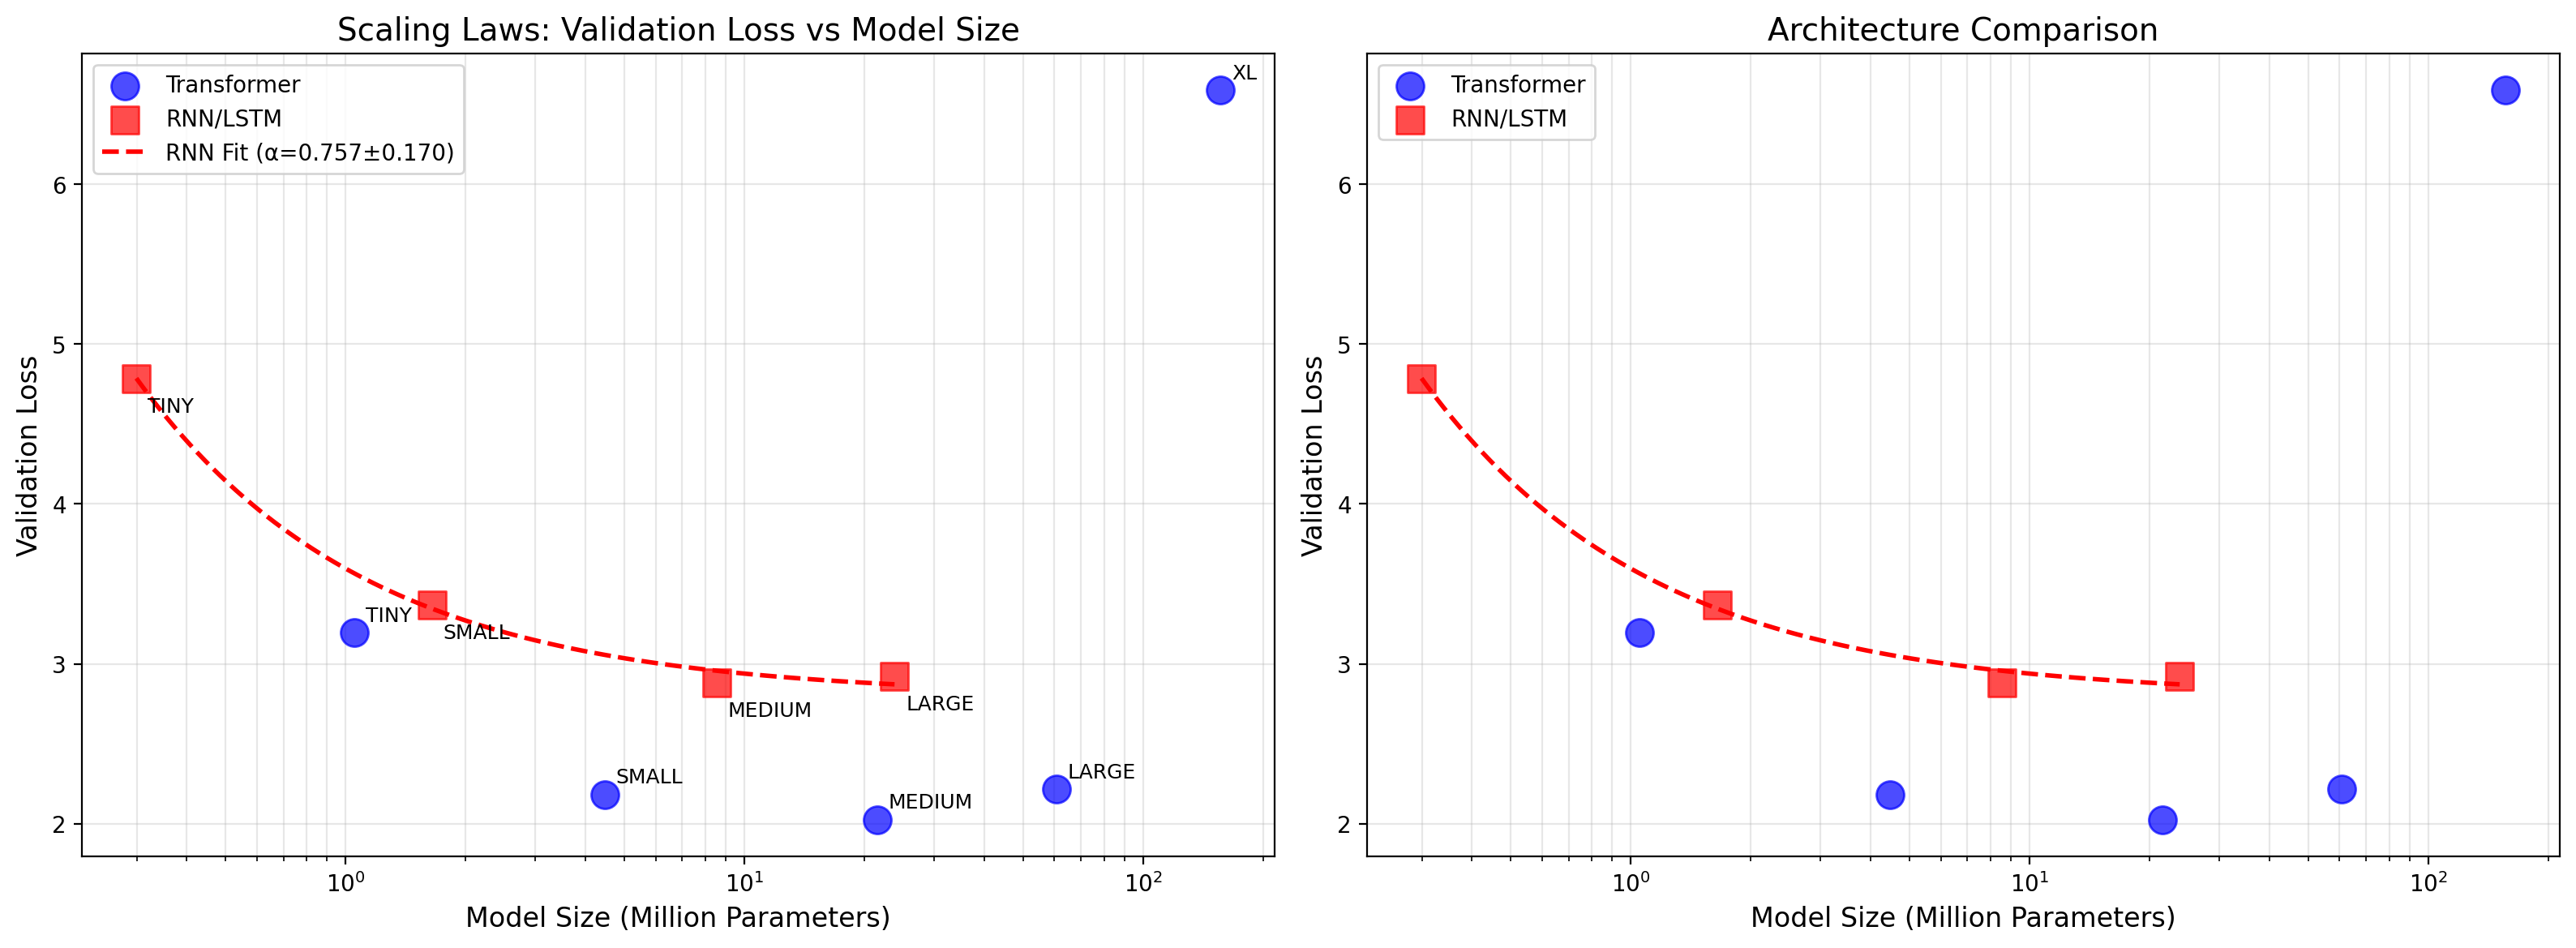


SCALING ANALYSIS SUMMARY

Transformer Models: 5
  Parameter range: 1.05M - 156.42M
  Loss range: 2.0257 - 6.5906

RNN/LSTM Models: 4
  Parameter range: 0.30M - 23.83M
  Loss range: 2.8833 - 4.7843
  Scaling exponent (α): 0.7569 ± 0.1698
  Power law: L = 27743.5507 * N^(-0.7569) + 2.7993

Results saved to: /content/symbolic-music-llm/data/processed/scaling_results.json


In [96]:
# Scaling Plots and Power Law Analysis
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def power_law(N, a, alpha, c):
    """Power law: L = a * N^(-alpha) + c"""
    return a * np.power(N, -alpha) + c

def fit_power_law(param_counts, losses):
    """Fit power law to scaling data."""
    p0 = [1.0, 0.1, 0.0]  # Initial guess
    try:
        popt, pcov = curve_fit(power_law, param_counts, losses, p0=p0, maxfev=10000)
        a, alpha, c = popt
        perr = np.sqrt(np.diag(pcov))
        return a, alpha, c, perr
    except Exception as e:
        print(f"Warning: Power law fitting failed: {e}")
        return None, None, None, None

# Prepare data for plotting
transformer_params = np.array([r['num_parameters'] for r in transformer_results])
transformer_losses = np.array([r['val_loss'] for r in transformer_results])

rnn_params = np.array([r['num_parameters'] for r in rnn_results])
rnn_losses = np.array([r['val_loss'] for r in rnn_results])

# Fit power laws
transformer_fit = fit_power_law(transformer_params, transformer_losses)
rnn_fit = fit_power_law(rnn_params, rnn_losses)

# Create combined comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Individual scaling plots
ax1.set_xscale('log')
ax1.scatter(transformer_params / 1e6, transformer_losses,
           s=150, alpha=0.7, label='Transformer', color='blue', zorder=3, marker='o')
ax1.scatter(rnn_params / 1e6, rnn_losses,
           s=150, alpha=0.7, label='RNN/LSTM', color='red', zorder=3, marker='s')

# Plot power law fits
if transformer_fit[0] is not None:
    a, alpha, c, perr = transformer_fit
    N_fit = np.logspace(np.log10(transformer_params.min()),
                       np.log10(transformer_params.max()), 100)
    L_fit = power_law(N_fit, a, alpha, c)
    ax1.plot(N_fit / 1e6, L_fit, 'b--', linewidth=2,
            label=f'Transformer Fit (α={alpha:.3f}±{perr[1]:.3f})', zorder=2)

if rnn_fit[0] is not None:
    a, alpha, c, perr = rnn_fit
    N_fit = np.logspace(np.log10(rnn_params.min()),
                       np.log10(rnn_params.max()), 100)
    L_fit = power_law(N_fit, a, alpha, c)
    ax1.plot(N_fit / 1e6, L_fit, 'r--', linewidth=2,
            label=f'RNN Fit (α={alpha:.3f}±{perr[1]:.3f})', zorder=2)

# Annotate points
for r in transformer_results:
    ax1.annotate(r['model_name'].upper(),
                (r['num_parameters']/1e6, r['val_loss']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

for r in rnn_results:
    ax1.annotate(r['model_name'].upper(),
                (r['num_parameters']/1e6, r['val_loss']),
                xytext=(5, -15), textcoords='offset points', fontsize=9)

ax1.set_xlabel('Model Size (Million Parameters)', fontsize=12)
ax1.set_ylabel('Validation Loss', fontsize=12)
ax1.set_title('Scaling Laws: Validation Loss vs Model Size', fontsize=14)
ax1.grid(True, alpha=0.3, which='both')
ax1.legend(fontsize=10)

# Plot 2: Comparison (overlay)
ax2.set_xscale('log')
ax2.scatter(transformer_params / 1e6, transformer_losses,
           s=150, alpha=0.7, label='Transformer', color='blue', zorder=3, marker='o')
ax2.scatter(rnn_params / 1e6, rnn_losses,
           s=150, alpha=0.7, label='RNN/LSTM', color='red', zorder=3, marker='s')

if transformer_fit[0] is not None:
    a, alpha, c, perr = transformer_fit
    N_fit = np.logspace(np.log10(transformer_params.min()),
                       np.log10(transformer_params.max()), 100)
    L_fit = power_law(N_fit, a, alpha, c)
    ax2.plot(N_fit / 1e6, L_fit, 'b--', linewidth=2, zorder=2)

if rnn_fit[0] is not None:
    a, alpha, c, perr = rnn_fit
    N_fit = np.logspace(np.log10(rnn_params.min()),
                       np.log10(rnn_params.max()), 100)
    L_fit = power_law(N_fit, a, alpha, c)
    ax2.plot(N_fit / 1e6, L_fit, 'r--', linewidth=2, zorder=2)

ax2.set_xlabel('Model Size (Million Parameters)', fontsize=12)
ax2.set_ylabel('Validation Loss', fontsize=12)
ax2.set_title('Architecture Comparison', fontsize=14)
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'scaling_plots.png', dpi=300, bbox_inches='tight')
print(f"Scaling plots saved to: {OUTPUT_DIR / 'scaling_plots.png'}")
plt.show()

# Print summary
print(f"\n{'='*60}")
print("SCALING ANALYSIS SUMMARY")
print(f"{'='*60}")
print(f"\nTransformer Models: {len(transformer_results)}")
print(f"  Parameter range: {transformer_params.min()/1e6:.2f}M - {transformer_params.max()/1e6:.2f}M")
print(f"  Loss range: {transformer_losses.min():.4f} - {transformer_losses.max():.4f}")
if transformer_fit[0] is not None:
    a, alpha, c, perr = transformer_fit
    print(f"  Scaling exponent (α): {alpha:.4f} ± {perr[1]:.4f}")
    print(f"  Power law: L = {a:.4f} * N^(-{alpha:.4f}) + {c:.4f}")

print(f"\nRNN/LSTM Models: {len(rnn_results)}")
print(f"  Parameter range: {rnn_params.min()/1e6:.2f}M - {rnn_params.max()/1e6:.2f}M")
print(f"  Loss range: {rnn_losses.min():.4f} - {rnn_losses.max():.4f}")
if rnn_fit[0] is not None:
    a, alpha, c, perr = rnn_fit
    print(f"  Scaling exponent (α): {alpha:.4f} ± {perr[1]:.4f}")
    print(f"  Power law: L = {a:.4f} * N^(-{alpha:.4f}) + {c:.4f}")

# Save results
results_summary = {
    'transformer': transformer_results,
    'rnn': rnn_results,
    'power_law_fits': {
        'transformer': {
            'a': float(transformer_fit[0]) if transformer_fit[0] is not None else None,
            'alpha': float(transformer_fit[1]) if transformer_fit[1] is not None else None,
            'c': float(transformer_fit[2]) if transformer_fit[2] is not None else None,
            'alpha_error': float(transformer_fit[3][1]) if transformer_fit[3] is not None else None
        },
        'rnn': {
            'a': float(rnn_fit[0]) if rnn_fit[0] is not None else None,
            'alpha': float(rnn_fit[1]) if rnn_fit[1] is not None else None,
            'c': float(rnn_fit[2]) if rnn_fit[2] is not None else None,
            'alpha_error': float(rnn_fit[3][1]) if rnn_fit[3] is not None else None
        }
    }
}

with open(OUTPUT_DIR / 'scaling_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\nResults saved to: {OUTPUT_DIR / 'scaling_results.json'}")


In [ ]:
# Train best model (largest transformer) for sample generation
print("="*60)
print("TRAINING BEST MODEL FOR SAMPLE GENERATION")
print("="*60)

# Set CUDA memory management to reduce fragmentation
if device.type == 'cuda':
    import os
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    print("Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to reduce fragmentation")
    # Clear any existing cache
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)

# Use the largest transformer configuration
# If XL model causes OOM errors, you can change this to 'large' instead
USE_XL_MODEL = True  # Set to False to use 'large' model instead (less memory)

if USE_XL_MODEL and 'xl' in TRANSFORMER_CONFIGS:
    best_config_name = 'xl'
else:
    # Use 'large' model instead (safer for memory)
    best_config_name = 'large' if 'large' in TRANSFORMER_CONFIGS else max(TRANSFORMER_CONFIGS.keys(),
                                                                           key=lambda k: TRANSFORMER_CONFIGS[k]['target_params'])

best_config = TRANSFORMER_CONFIGS[best_config_name]

print(f"Training {best_config_name.upper()} model for sample generation...")
print(f"Config: {best_config}")

    # For XL model, use reduced settings to avoid OOM
    if best_config_name == 'xl':
        # Reduce max_seq_length for XL to save memory
        best_config = best_config.copy()
        best_config['max_seq_length'] = min(best_config['max_seq_length'], 2000)  # Cap at 2000
        print(f"WARNING: Using reduced max_seq_length for XL: {best_config['max_seq_length']} (to avoid OOM)")

# Initialize best model
best_model = MusicTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=best_config['d_model'],
    n_layers=best_config['n_layers'],
    n_heads=best_config['n_heads'],
    d_ff=best_config['d_ff'],
    max_seq_length=best_config['max_seq_length'],
    dropout=best_config['dropout']
).to(device)

num_params = best_model.count_parameters()
print(f"Model parameters: {num_params:,} ({num_params/1e6:.2f}M)")

# Use smaller batch size for XL model to avoid OOM
if best_config_name == 'xl':
    # For XL model, use very small batch size to avoid OOM
    # If you still get OOM errors, reduce this further (e.g., 5000 or 2000)
    BEST_BATCH_SIZE_TOKENS = 5000  # Very small for XL to avoid OOM
    print(f"WARNING: Using very small batch size for XL: {BEST_BATCH_SIZE_TOKENS:,} tokens")
    print(f"  If you still get OOM errors, reduce BEST_BATCH_SIZE_TOKENS to 2000 or use 'large' model instead")
else:
    BEST_BATCH_SIZE_TOKENS = BATCH_SIZE_TOKENS

# Create data loaders with appropriate batch size
train_loader = MusicDataLoader(
    train_path,
    batch_size_tokens=BEST_BATCH_SIZE_TOKENS,
    max_seq_length=best_config['max_seq_length'],
    shuffle=True
)

val_loader = MusicDataLoader(
    val_path,
    batch_size_tokens=BEST_BATCH_SIZE_TOKENS,
    max_seq_length=best_config['max_seq_length'],
    shuffle=False
)

# Setup optimizer and scheduler
estimated_steps = len(train_loader) if hasattr(train_loader, '__len__') else 1000
optimizer = AdamW(best_model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = get_lr_schedule(optimizer, estimated_steps, warmup_steps=0)

# Train for multiple epochs (more than scaling study)
NUM_EPOCHS_BEST = 3  # Train longer for better samples
print(f"\nTraining for {NUM_EPOCHS_BEST} epochs...")

for epoch in range(NUM_EPOCHS_BEST):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_BEST}")
    print("-" * 60)

    # Clear CUDA cache before each epoch
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        print(f"GPU Memory before epoch: {torch.cuda.memory_allocated(device) / 1024**2:.1f} MB / {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

    train_loss = train_one_epoch(
        best_model, train_loader, optimizer, scheduler, device,
        log_interval=LOG_INTERVAL
    )

    # Clear cache after training
    if device.type == 'cuda':
        torch.cuda.empty_cache()

    val_loss = evaluate(best_model, val_loader, device)

    # Clear cache after evaluation
    if device.type == 'cuda':
        torch.cuda.empty_cache()

    print(f"Epoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    if device.type == 'cuda':
        print(f"  GPU Memory: {torch.cuda.memory_allocated(device) / 1024**2:.1f} MB")

# Final evaluation on test set
test_path = OUTPUT_DIR / "tokenized" / "test" / "data.json"
test_loader = MusicDataLoader(
    test_path,
    batch_size_tokens=BEST_BATCH_SIZE_TOKENS,  # Use reduced batch size
    max_seq_length=best_config['max_seq_length'],
    shuffle=False
)

test_loss = evaluate(best_model, test_loader, device)
print(f"\nFinal Test Loss: {test_loss:.4f}")

# Save best model
best_model_path = OUTPUT_DIR / "best_model.pt"
torch.save({
    'model_state_dict': best_model.state_dict(),
    'model_config': best_config,
    'vocab_size': tokenizer.vocab_size,
    'num_parameters': num_params,
    'test_loss': test_loss,
}, best_model_path)

print(f"\nBest model saved to: {best_model_path}")


TRAINING BEST MODEL FOR SAMPLE GENERATION
✓ Set PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to reduce fragmentation
Training XL model for sample generation...
Config: {'d_model': 1024, 'n_layers': 12, 'n_heads': 16, 'd_ff': 4096, 'max_seq_length': 5000, 'dropout': 0.1, 'target_params': 100000000.0}
⚠ Using reduced max_seq_length for XL: 2000 (to avoid OOM)
Model parameters: 153,345,024 (153.35M)
⚠ Using very small batch size for XL: 5,000 tokens
  If you still get OOM errors, reduce BEST_BATCH_SIZE_TOKENS to 2000 or use 'large' model instead
Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/train/data.json...
Loaded 294 sequences
Average sequence length: 1869.8
Loading sequences from /content/symbolic-music-llm/data/processed/tokenized/val/data.json...
Loaded 3 sequences
Average sequence length: 2000.0

Training for 3 epochs...

Epoch 1/3
------------------------------------------------------------
GPU Memory before epoch: 607.3 MB / 39.6 GB
Step      0 |

In [ ]:
# Generate music samples
print("\n" + "="*60)
print("GENERATING MUSIC SAMPLES")
print("="*60)

best_model.eval()
samples_dir = OUTPUT_DIR / "samples"
samples_dir.mkdir(exist_ok=True)

generated_samples = []

# Generate multiple samples
NUM_SAMPLES = 10
MAX_NEW_TOKENS = 500  # Generate 500 tokens per sample

print(f"Generating {NUM_SAMPLES} samples...")

for i in range(NUM_SAMPLES):
    # Unconditional generation: start with a random token or special token
    start_token_id = tokenizer.token_to_id.get('<START>', 2)  # Use START token if available
    if start_token_id not in tokenizer.token_to_id.values():
        # If no START token, use a common note token
        start_token_id = tokenizer.token_to_id.get('C', 5)  # Start with C note

    start_tokens = torch.tensor([[start_token_id]], device=device)

    with torch.no_grad():
        generated = best_model.generate(
            start_tokens,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=1.0,
            top_k=50  # Top-k sampling for diversity
        )

    # Decode generated tokens
    generated_tokens = generated[0].cpu().tolist()
    generated_abc = tokenizer.decode(generated_tokens)

    # Save sample
    sample_path = samples_dir / f"sample_{i+1}.abc"
    with open(sample_path, 'w') as f:
        f.write(generated_abc)

    generated_samples.append({
        'sample_id': i+1,
        'tokens': generated_tokens,
        'abc': generated_abc,
        'length': len(generated_tokens)
    })

    print(f"Sample {i+1}: {len(generated_tokens)} tokens")
    print(f"  Saved to: {sample_path}")
    print(f"  Preview: {generated_abc[:100]}...")

# Save samples metadata
with open(samples_dir / "samples_metadata.json", 'w') as f:
    json.dump(generated_samples, f, indent=2)

print(f"\nGenerated {NUM_SAMPLES} samples")
print(f"Samples saved to: {samples_dir}")

# Evaluate sample quality
print("\n" + "="*60)
print("SAMPLE EVALUATION")
print("="*60)

# Try to convert samples to MIDI for validation
valid_samples = 0
for i, sample in enumerate(generated_samples):
    try:
        # Try to parse ABC notation (basic validation)
        abc_str = sample['abc']
        # Check if it has basic ABC structure
        if 'X:' in abc_str or len(abc_str.strip()) > 10:
            valid_samples += 1
    except:
        pass

print(f"Valid samples (basic syntax check): {valid_samples}/{NUM_SAMPLES} ({valid_samples/NUM_SAMPLES*100:.1f}%)")
print(f"Average sample length: {np.mean([s['length'] for s in generated_samples]):.1f} tokens")
print(f"Test set perplexity: {np.exp(test_loss):.2f}")

# Save evaluation results
evaluation_results = {
    'test_loss': float(test_loss),
    'test_perplexity': float(np.exp(test_loss)),
    'num_samples': NUM_SAMPLES,
    'valid_samples': valid_samples,
    'valid_percentage': float(valid_samples/NUM_SAMPLES*100),
    'average_sample_length': float(np.mean([s['length'] for s in generated_samples])),
    'samples_dir': str(samples_dir)
}

with open(OUTPUT_DIR / 'evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print(f"\nEvaluation results saved to: {OUTPUT_DIR / 'evaluation_results.json'}")



GENERATING MUSIC SAMPLES
Generating 10 samples...
Sample 1: 501 tokens
  Saved to: /content/symbolic-music-llm/data/processed/samples/sample_1.abc
  Preview: <START> K K K : DUR:4 L DUR:4 L : : DUR:4 : M : DUR:2 C DUR:2 G DUR:2 D | D z DUR:2 G DUR:2 F DUR:2 ...
Sample 2: 501 tokens
  Saved to: /content/symbolic-music-llm/data/processed/samples/sample_2.abc
  Preview: <START> : L M M K K M M M M M M M M M K M M K K M M M M M M M M M M M M M M M M M M M M M M M M M M ...
Sample 3: 501 tokens
  Saved to: /content/symbolic-music-llm/data/processed/samples/sample_3.abc
  Preview: <START> : DUR:1 M : DUR:4 / DUR:4 L : DUR:4 / DUR:4 K : B m z DUR:8 z DUR:8 z DUR:8 A DUR:8 G DUR:8 ...
Sample 4: 501 tokens
  Saved to: /content/symbolic-music-llm/data/processed/samples/sample_4.abc
  Preview: <START> : DUR:1 M : DUR:2 DUR:4 DUR:4 L M : DUR:4 K : : | : DUR:4 B DUR:2 | z DUR:8 z DUR:8 | z DUR:...
Sample 5: 501 tokens
  Saved to: /content/symbolic-music-llm/data/processed/samples/sample_5.abc
  Pr

# Part 18: Generate Music Samples

This section generates music samples from the trained model and evaluates their quality. Based on `experiments/sample_generation.py`.

Samples are generated using top-k sampling for diversity and saved in ABC notation format.

# Part 19: Summary and Next Steps

This notebook has completed the full pipeline for the symbolic music LLM scaling laws project.


In [ ]:
# Final Summary
print("="*60)
print("PROJECT COMPLETE - SUMMARY")
print("="*60)

print("\nData Collection and Preprocessing:")
print(f"  - Processed {len(abc_data):,} MIDI files")
print(f"  - Vocabulary size: {tokenizer.vocab_size:,}")
print(f"  - Train/Val/Test splits created")

print("\nTransformer Scaling Study:")
print(f"  - Trained {len(transformer_results)} transformer models")
for r in transformer_results:
    print(f"    {r['model_name']:8s}: {r['num_parameters']/1e6:6.2f}M params, Val Loss: {r['val_loss']:.4f}")

print("\nRNN Scaling Study:")
print(f"  - Trained {len(rnn_results)} RNN/LSTM models")
for r in rnn_results:
    print(f"    {r['model_name']:8s}: {r['num_parameters']/1e6:6.2f}M params, Val Loss: {r['val_loss']:.4f}")

print("\nScaling Analysis:")
if transformer_fit[0] is not None:
    a, alpha, c, perr = transformer_fit
    print(f"  - Transformer scaling exponent: α = {alpha:.4f} ± {perr[1]:.4f}")
if rnn_fit[0] is not None:
    a, alpha, c, perr = rnn_fit
    print(f"  - RNN scaling exponent: α = {alpha:.4f} ± {perr[1]:.4f}")

print("\nSample Generation:")
print(f"  - Generated {NUM_SAMPLES} music samples")
print(f"  - Test perplexity: {np.exp(test_loss):.2f}")
print(f"  - Valid samples: {valid_samples}/{NUM_SAMPLES}")

print("\nOutput Files:")
print(f"  - Scaling plots: {OUTPUT_DIR / 'scaling_plots.png'}")
print(f"  - Scaling results: {OUTPUT_DIR / 'scaling_results.json'}")
print(f"  - Best model: {OUTPUT_DIR / 'best_model.pt'}")
print(f"  - Generated samples: {samples_dir}")
print(f"  - Evaluation results: {OUTPUT_DIR / 'evaluation_results.json'}")

print("\n" + "="*60)
print("Next Steps for Report:")
print("="*60)
print("1. Analyze scaling plots and power law fits")
print("2. Compare transformer vs RNN scaling behavior")
print("3. Evaluate generated samples qualitatively")
print("4. Convert ABC samples to MIDI/audio for playback")
print("5. Document design decisions and insights")
print("6. Write up findings in LaTeX report")
print("="*60)


PROJECT COMPLETE - SUMMARY

✓ Data Collection and Preprocessing:
  - Processed 1,000 MIDI files
  - Vocabulary size: 137
  - Train/Val/Test splits created

✓ Transformer Scaling Study:
  - Trained 5 transformer models
    tiny    :   1.05M params, Val Loss: 3.1949
    small   :   4.47M params, Val Loss: 2.1832
    medium  :  21.55M params, Val Loss: 2.0257
    large   :  60.65M params, Val Loss: 2.2165
    xl      : 156.42M params, Val Loss: 6.5906

✓ RNN Scaling Study:
  - Trained 4 RNN/LSTM models
    tiny    :   0.30M params, Val Loss: 4.7843
    small   :   1.65M params, Val Loss: 3.3693
    medium  :   8.55M params, Val Loss: 2.8833
    large   :  23.83M params, Val Loss: 2.9238

✓ Scaling Analysis:
  - RNN scaling exponent: α = 0.7569 ± 0.1698

✓ Sample Generation:
  - Generated 10 music samples
  - Test perplexity: 7.10
  - Valid samples: 10/10

📁 Output Files:
  - Scaling plots: /content/symbolic-music-llm/data/processed/scaling_plots.png
  - Scaling results: /content/symbolic-